In [5]:
from ibl_pipeline.analyses import behavior
from ibl_pipeline import behavior as behavior_ingest
from ibl_pipeline import subject, acquisition
from ibl_pipeline.utils import psychofit as psy
import numpy as np
import datetime
import datajoint as dj

import seaborn as sns
import pandas as pd

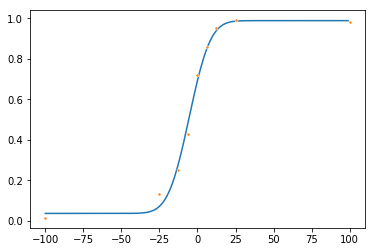

In [6]:
# Regular plotting
key = {'lab_name': 'churchlandlab',
   'subject_nickname': 'CSHL_002',
   'session_start_time': datetime.datetime(2019, 4, 4, 12, 33, 38)}
session = behavior.PsychResults & key
contrasts, prob_right, threshold, bias, lapse_low, lapse_high, n_trials, n_trials_right = session.fetch1(
    'signed_contrasts', 'prob_choose_right', 'threshold', 'bias', 'lapse_low', 'lapse_high', 'n_trials_stim', 'n_trials_stim_right')
pars = [bias, threshold, lapse_low, lapse_high]
contrasts = contrasts * 100
contrasts_fit = np.arange(-100, 100)
prob_right_fit = psy.erf_psycho_2gammas(pars, contrasts_fit)
sns.lineplot(contrasts_fit, prob_right_fit)
sns.lineplot(x=contrasts, y=prob_right, err_style="bars", linewidth=0, linestyle='None', mew=0.5,
        marker='.', ci=68)

In [7]:
import plotly
import plotly.graph_objs as go
import statsmodels.stats.proportion as smp
plotly.offline.init_notebook_mode(connected=True)

ci = smp.proportion_confint(
    n_trials_right, n_trials, alpha=0.032, method='normal') - prob_right

behavior_data = dict(
    x = contrasts.tolist(),
    y = prob_right.tolist(),
    error_y = dict(
                type='data',
                array=ci[0].tolist(),
                arrayminus=np.negative(ci[1]).tolist(),
                visible=True
        ),
    mode = 'markers',
    name = 'data'
)

behavior_fit = dict(
    x = contrasts_fit.tolist(),
    y = prob_right_fit.tolist(),
    name = 'model fits'
)

data = [behavior_data, behavior_fit]
layout = go.Layout(
    width=600,
    height=400,
    title='Psychometric Curve', 
    xaxis={'title':'Contrast(%)'}, 
    yaxis={'title':'Probability choose right'}
)

fig = go.Figure(data=[go.Scatter(behavior_data), go.Scatter(behavior_fit)], layout=layout)
plotly.offline.iplot(fig)

In [61]:
f = open("psych_results.json","w")
s = json.dumps(fig.to_plotly_json())
f.write(s)
f.close()